In [1]:
import math
import pandas as pd
import numpy as np
from operator import itemgetter

In [2]:
import math
import pandas as pd
import numpy as np
from operator import itemgetter


import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics


from sklearn import tree
from sklearn.tree import _tree

from sklearn.ensemble import RandomForestRegressor 
from sklearn.ensemble import RandomForestClassifier 

from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

import warnings
warnings.filterwarnings("ignore")



In [4]:
df = pd.read_csv( "C:\\Users\\aroon\\Desktop\\MSDS\\422\\MSDS422\\Unit 3\\ImputedDataset.csv" )
dt = df.dtypes
TARGET_F = "TARGET_BAD_FLAG"
TARGET_A = "TARGET_LOSS_AMT"


In [5]:
"""
SPLIT DATA
"""

X = df.copy()
X = X.drop( TARGET_F, axis=1 )
X = X.drop( TARGET_A, axis=1 )

Y = df[ [TARGET_F, TARGET_A] ]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=2)
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, test_size=0.2 )

##print( "FLAG DATA" )
##print( "TRAINING = ", X_train.shape )
##print( "TEST = ", X_test.shape )


F = ~ Y_train[ TARGET_A ].isna()
W_train = X_train[F].copy()
Z_train = Y_train[F].copy()

F = ~ Y_test[ TARGET_A ].isna()
W_test = X_test[F].copy()
Z_test = Y_test[F].copy()

print( Z_train.describe() )
print( Z_test.describe() )
print( "\n\n")



       TARGET_BAD_FLAG  TARGET_LOSS_AMT
count            941.0       941.000000
mean               1.0     13634.824655
std                0.0     10836.172568
min                1.0       224.000000
25%                1.0      5837.000000
50%                1.0     11266.000000
75%                1.0     18069.000000
max                1.0     78987.000000
       TARGET_BAD_FLAG  TARGET_LOSS_AMT
count            248.0       248.000000
mean               1.0     12578.879032
std                0.0     10833.019569
min                1.0       320.000000
25%                1.0      4921.000000
50%                1.0      9693.500000
75%                1.0     15601.250000
max                1.0     73946.000000





In [6]:
import tensorflow as tf

In [7]:

from sklearn.preprocessing import MinMaxScaler
theScaler = MinMaxScaler()
theScaler.fit( X_train )

MinMaxScaler()

In [8]:
def get_TF_ProbAccuracyScores( NAME, MODEL, X, Y ) :
    probs = MODEL.predict_proba( X )
    pred_list = []
    for p in probs :
        pred_list.append( np.argmax( p ) )
    pred = np.array( pred_list )
    acc_score = metrics.accuracy_score(Y, pred)
    p1 = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve( Y, p1)
    auc = metrics.auc(fpr,tpr)
    return [NAME, acc_score, fpr, tpr, auc]

In [9]:
WHO = "Tensor_FLow"

U_train = theScaler.transform( X_train )
U_test = theScaler.transform( X_test )

U_train = pd.DataFrame( U_train )
U_test = pd.DataFrame( U_test )

U_train.columns = list( X_train.columns.values )
U_test.columns = list( X_train.columns.values )

In [12]:
"""
MODEL ACCURACY METRICS AND FUNCTIONS
"""

def getProbAccuracyScores( NAME, MODEL, X, Y ) :
    pred = MODEL.predict( X )
    probs = MODEL.predict_proba( X )
    acc_score = metrics.accuracy_score(Y, pred)
    p1 = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve( Y, p1)
    auc = metrics.auc(fpr,tpr)
    return [NAME, acc_score, fpr, tpr, auc]

def getEnsembleTreeVars( ENSTREE, varNames ) :
    importance = ENSTREE.feature_importances_
    index = np.argsort(importance)
    theList = []
    for i in index :
        imp_val = importance[i]
        if imp_val > np.average( ENSTREE.feature_importances_ ) :
            v = int( imp_val / np.max( ENSTREE.feature_importances_ ) * 100 )
            theList.append( ( varNames[i], v ) )
    theList = sorted(theList,key=itemgetter(1),reverse=True)
    return theList

def getAmtAccuracyScores( NAME, MODEL, X, Y ) :
    pred = MODEL.predict( X )
    MEAN = Y.mean()
    RMSE = math.sqrt( metrics.mean_squared_error( Y, pred))
    return [NAME, RMSE, MEAN]

def getTreeVars( TREE, varNames ) :    
    tree_ = TREE.tree_    
    varName = [ varNames[i] 
               if i != _tree.TREE_UNDEFINED 
               else "undefined!" 
               for i in tree_.feature ]    
    nameSet = set()    
    for i in tree_.feature :        
        if i != _tree.TREE_UNDEFINED :            
            nameSet.add( i )    
    nameList = list( nameSet )    
    parameter_list = list()    
    for i in nameList :        
        parameter_list.append( varNames[i] )    
    return parameter_list

def print_ROC_Curve( TITLE, LIST ) :
    fig = plt.figure(figsize=(6,4))
    plt.title( TITLE )
    for theResults in LIST :
        NAME = theResults[0]
        fpr = theResults[2]
        tpr = theResults[3]
        auc = theResults[4]
        theLabel = "AUC " + NAME + ' %0.2f' % auc
        plt.plot(fpr, tpr, label = theLabel )
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
def print_Accuracy( TITLE, LIST ) :
    print( TITLE )
    print( "======" )
    for theResults in LIST :
        NAME = theResults[0]
        ACC = theResults[1]
        print( NAME, " = ", ACC )
    print( "------\n\n" )

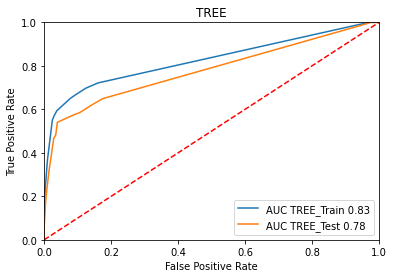

TREE CLASSIFICATION ACCURACY
TREE_Train  =  0.8917785234899329
TREE_Test  =  0.8649328859060402
------


TREE RMSE ACCURACY
TREE_Train  =  4638.616383413549
TREE  =  6488.967497676028
------




In [43]:
# DECISION TREE - LOAN DEFAULT

WHO = "TREE"

BAD = tree.DecisionTreeClassifier(max_depth = 5 )
BAD = BAD.fit( X_train, Y_train[ TARGET_F ] )

TRAIN_BAD = getProbAccuracyScores( WHO + "_Train", BAD, X_train, Y_train[ TARGET_F ] )
TEST_BAD = getProbAccuracyScores( WHO + "_Test", BAD, X_test, Y_test[ TARGET_F ] )

print_ROC_Curve( WHO, [ TRAIN_BAD, TEST_BAD ] ) 
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_BAD, TEST_BAD ] )

feature_cols = list( X.columns.values )



WHO = "TREE"
AMT = tree.DecisionTreeRegressor( max_depth= 4 )
AMT = AMT.fit( W_train, Z_train[TARGET_A] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train, Z_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, W_test, Z_test[TARGET_A] )
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

feature_cols = list( X.columns.values )
vars_tree_amt = getTreeVars( AMT, feature_cols ) 
tree.export_graphviz(AMT,out_file='tree_a.txt',filled=True, rounded=True, feature_names = feature_cols, impurity=False, precision=0  )

TREE_CLM = TRAIN_BAD.copy()
TREE_AMT = TEST_AMT.copy()


In [30]:
TREE_AMT

['TREE', 6488.967497676028, 12578.879032258064]

In [14]:
tree.export_graphviz(BAD,out_file='tree_f.txt',filled=True, rounded=True, feature_names = feature_cols, impurity=False, class_names=["Good","Bad"]  )

vars_tree_flag = getTreeVars( BAD, feature_cols ) 
vars_tree_flag

['LOAN',
 'MORTDUE',
 'VALUE',
 'DEROG',
 'DELINQ',
 'CLAGE',
 'NINQ',
 'CLNO',
 'DEBTINC']

In [15]:
U_train = U_train[ vars_tree_flag ]
U_test = U_test[ vars_tree_flag ]

In [40]:
# define functions and layers in a variable

F_theShapeSize = U_train.shape[1]
#F_theActivation = tf.keras.activations.relu
F_theActivation_input = tf.keras.activations.relu
F_theActivation_hidden = tf.keras.activations.sigmoid
F_theLossMetric = tf.keras.losses.SparseCategoricalCrossentropy()
F_theOptimizer = tf.keras.optimizers.Adam()
F_theEpochs = 100

#F_theUnits = int( 2*F_theShapeSize / 3 )
F_theUnits = int( 2*F_theShapeSize/3)

F_LAYER_01 = tf.keras.layers.Dense( units=F_theUnits, activation=F_theActivation_input, input_dim=F_theShapeSize )
F_LAYER_DROP = tf.keras.layers.Dropout( 0.2 )
F_LAYER_02 = tf.keras.layers.Dense( units=F_theUnits, activation=F_theActivation_hidden )
F_LAYER_OUTPUT = tf.keras.layers.Dense( units=2, activation=tf.keras.activations.softmax )



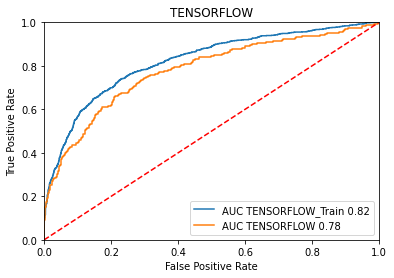

TENSORFLOW CLASSIFICATION ACCURACY
TENSORFLOW_Train  =  0.8406040268456376
TENSORFLOW  =  0.8271812080536913
------




In [41]:
WHO = "TENSORFLOW"
CLM = tf.keras.Sequential()
CLM.add( F_LAYER_01 )
CLM.add( F_LAYER_DROP )
CLM.add( F_LAYER_02 )
CLM.add( F_LAYER_OUTPUT )
CLM.compile( loss=F_theLossMetric, optimizer=F_theOptimizer)
CLM.fit( U_train, Y_train[TARGET_F], epochs=F_theEpochs, verbose=False )

TRAIN_CLM = get_TF_ProbAccuracyScores( WHO + "_Train", CLM, U_train, Y_train[ TARGET_F ] )
TEST_CLM = get_TF_ProbAccuracyScores( WHO, CLM, U_test, Y_test[ TARGET_F ] )

print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] ) 
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )

In [25]:
CLM.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 6)                 60        
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 14        
Total params: 74
Trainable params: 74
Non-trainable params: 0
_________________________________________________________________


In [47]:
"""
GRADIENT BOOSTING
"""
WHO = "GB"

CLM = GradientBoostingClassifier( random_state=1  )
CLM = CLM.fit( X_train, Y_train[ TARGET_F ] )

TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, X_train, Y_train[ TARGET_F ] )
TEST_CLM = getProbAccuracyScores( WHO, CLM, X_test, Y_test[ TARGET_F ] )



feature_cols = list( X.columns.values )
vars_GB_flag = getEnsembleTreeVars( CLM, feature_cols )

#vars_GB_flag

AMT = GradientBoostingRegressor(random_state=1)
AMT = AMT.fit( W_train, Z_train[TARGET_A] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train, Z_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, W_test, Z_test[TARGET_A] )

feature_cols = list( X.columns.values )
vars_GB_amt = getEnsembleTreeVars( AMT, feature_cols )

##for i in vars_RF_amt :
##    print( i )

GB_CLM = TEST_CLM.copy()
GB_AMT = TEST_AMT.copy()

In [54]:
# Gradient Boosting 

WHO = "REG_GB"


print("\n\n")
GB_flag = []
for i in vars_GB_flag :
    print(i)
    theVar = i[0]
    GB_flag.append( theVar )

print("\n\n")
GB_amt = []
for i in vars_GB_amt :
    print(i)
    theVar = i[0]
    GB_amt.append( theVar )





('DEBTINC', 100)
('DEROG', 58)
('DELINQ', 42)



('LOAN', 100)


In [55]:
V_train = theScaler.transform( W_train )
V_test = theScaler.transform( W_test )

V_train = pd.DataFrame( V_train )
V_test = pd.DataFrame( V_test )

V_train.columns = list( W_train.columns.values )
V_test.columns = list( W_train.columns.values )

V_train = V_train[ GB_amt ]
V_test = V_test[ GB_amt ]

In [65]:
A_theShapeSize = V_train.shape[1]

A_theActivation = tf.keras.activations.relu
A_theActivation_hidden = tf.keras.activations.tanh

A_theLossMetric = tf.keras.losses.MeanSquaredError()
A_theOptimizer = tf.keras.optimizers.Adam()
A_theEpochs = 800

A_theUnits = int( 2*A_theShapeSize  )

A_LAYER_01 = tf.keras.layers.Dense( units=A_theUnits, activation=A_theActivation, input_dim=A_theShapeSize )
A_LAYER_DROP = tf.keras.layers.Dropout( 0.2 )
A_LAYER_02 = tf.keras.layers.Dense( units=A_theUnits, activation=A_theActivation_hidden )
A_LAYER_OUTPUT = tf.keras.layers.Dense( units=1, activation=tf.keras.activations.linear )

AMT = tf.keras.Sequential()
AMT.add( A_LAYER_01 )
#AMT.add( A_LAYER_DROP )
AMT.add( A_LAYER_02 )
AMT.add( A_LAYER_OUTPUT )
AMT.compile( loss=A_theLossMetric, optimizer=A_theOptimizer)
AMT.fit( V_train, Z_train[TARGET_A], epochs=A_theEpochs, verbose=False )


TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, V_train[GB_amt], Z_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, V_test[GB_amt], Z_test[TARGET_A] )
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

TF_CLM = TEST_CLM.copy()
TF_AMT = TEST_AMT.copy()


REG_GB RMSE ACCURACY
REG_GB_Train  =  17355.621938132714
REG_GB  =  16531.033039704922
------


